In [ ]:
import torch
import random
import pandas as pd
import json
import pickle
import torch.utils.data
import json
import math
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer
import json
import os

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, image_dir, transform, tokenizer, max_len=20):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data) * 3  # Assuming 3 captions per image

    def __getitem__(self, idx):
        original_idx = idx // 3
        caption_idx = idx % 3

        item = self.data[original_idx]
        img_path = os.path.join(self.image_dir, item['filename'])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Tokenize caption with <SOS> and <EOS>
        caption = item['sentences'][caption_idx]
        encoded_caption = self.tokenizer.encode(
            caption,
            add_special_tokens=False,  # Disable BERT's default special tokens
            max_length=self.max_len - 2,  # Reserve space for <SOS> and <EOS>
            padding="max_length",
            truncation=True,
        )
        encoded_caption = [tokenizer.bos_token_id] + encoded_caption + [tokenizer.eos_token_id]
        encoded_caption = encoded_caption[:self.max_len]  # Ensure max_len
        encoded_caption += [tokenizer.pad_token_id] * (self.max_len - len(encoded_caption))  # Pad if necessary

        return image, torch.tensor(encoded_caption)


In [ ]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Add special tokens
tokenizer.add_special_tokens(
    {"pad_token": "<PAD>", "unk_token": "<UNK>", "bos_token": "<SOS>", "eos_token": "<EOS>"}
)

# Verify that the special tokens have been added
sos_token_id = tokenizer.convert_tokens_to_ids("<SOS>")
eos_token_id = tokenizer.convert_tokens_to_ids("<EOS>")
pad_token_id = tokenizer.pad_token_id
unk_token_id = tokenizer.unk_token_id

print(f"<SOS> token ID: {sos_token_id}")
print(f"<EOS> token ID: {eos_token_id}")
print(f"<PAD> token ID: {pad_token_id}")
print(f"<UNK> token ID: {unk_token_id}")


<SOS> token ID: 30524
<EOS> token ID: 30525
<PAD> token ID: 30522
<UNK> token ID: 30523


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Project/Image Captioning/flickr8k_simplified.json", "r") as file:
    data = json.load(file)

image_dir = "/content/drive/MyDrive/Project/Image Captioning/Flicker8k_Dataset_reduced_size"

# with open("/content/drive/MyDrive/Deep_Learning/flickr8k_simplified.json", "r") as file:
#     data = json.load(file)

# image_dir = "/content/drive/MyDrive/Deep_Learning/Resized_Images"

train_data = [item for item in data if item["split"] == "train"]
train_dataset = ImageCaptionDataset(train_data, image_dir, transform, tokenizer)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_data = [item for item in data if item['split'] == 'val']
test_data = [item for item in data if item['split'] == 'test']

In [ ]:
val_dataset = ImageCaptionDataset(val_data, image_dir, transform, tokenizer)
test_dataset = ImageCaptionDataset(test_data, image_dir, transform, tokenizer)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
# Fetch a batch from the DataLoader
images, labels = next(iter(train_dataloader))

# Decode a few captions
for i in range(5):
    tokenized_caption = labels[i].tolist()
    decoded_caption = tokenizer.decode(tokenized_caption, skip_special_tokens=False)  # Include special tokens
    print(f"Sample {i+1}:")
    print(f"Tokenized: {tokenized_caption}")
    print(f"Decoded Caption: {decoded_caption}")
    print()


Sample 1:
Tokenized: [30524, 1037, 2177, 1997, 2111, 3061, 2648, 1997, 1037, 2311, 1012, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30525]
Decoded Caption: <SOS> a group of people standing outside of a building. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <EOS>

Sample 2:
Tokenized: [30524, 1037, 2829, 1998, 2304, 3899, 2652, 1999, 1996, 4586, 1012, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30525]
Decoded Caption: <SOS> a brown and black dog playing in the snow. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <EOS>

Sample 3:
Tokenized: [30524, 2048, 2336, 2007, 2829, 2606, 1999, 1037, 8260, 1997, 1037, 2482, 1012, 30522, 30522, 30522, 30522, 30522, 30522, 30525]
Decoded Caption: <SOS> two children with brown hair in a trunk of a car. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <EOS>

Sample 4:
Tokenized: [30524, 2273, 3788, 1999, 1037, 2690, 2789, 3006, 1012, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30525]
Decoded Caption: <SOS> men 

In [ ]:
vocab_size = len(tokenizer)  # The total number of tokens in the tokenizer's vocabulary
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 30526


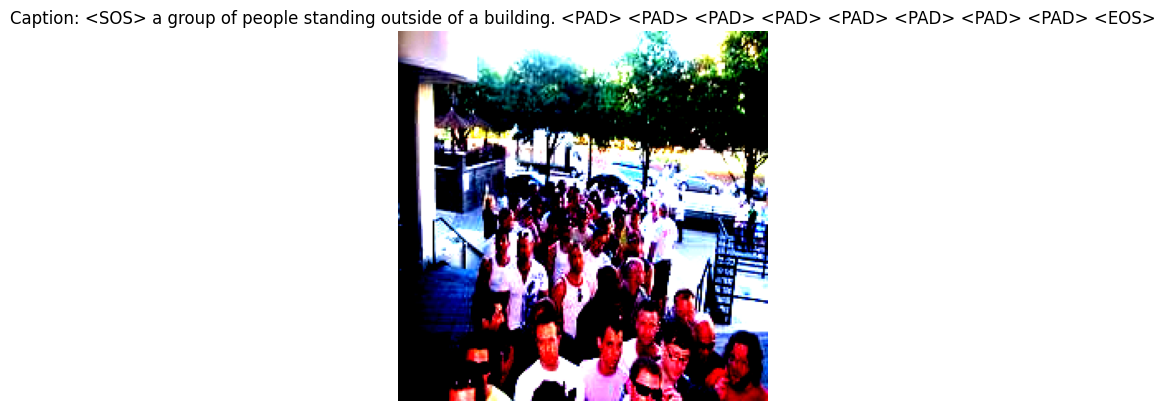

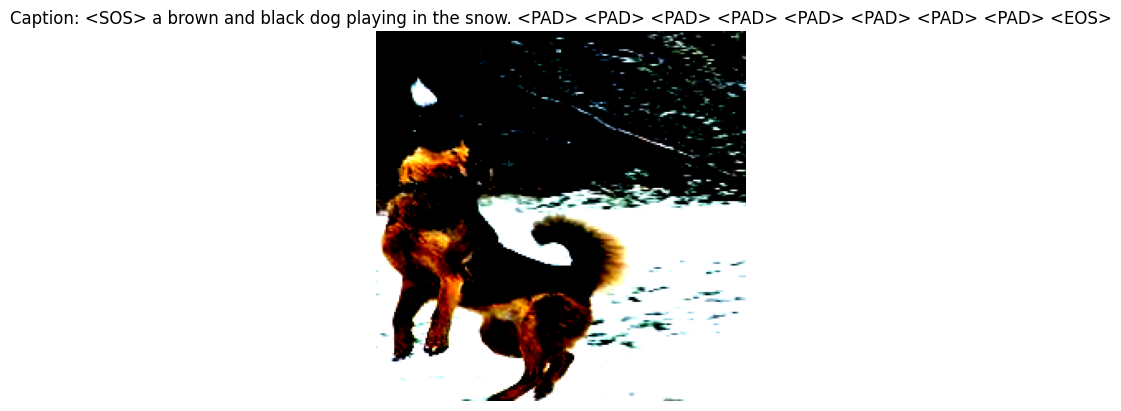

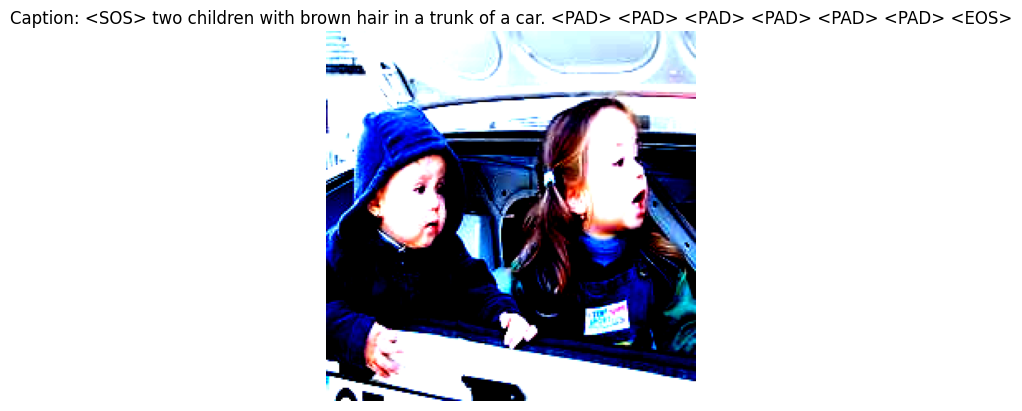

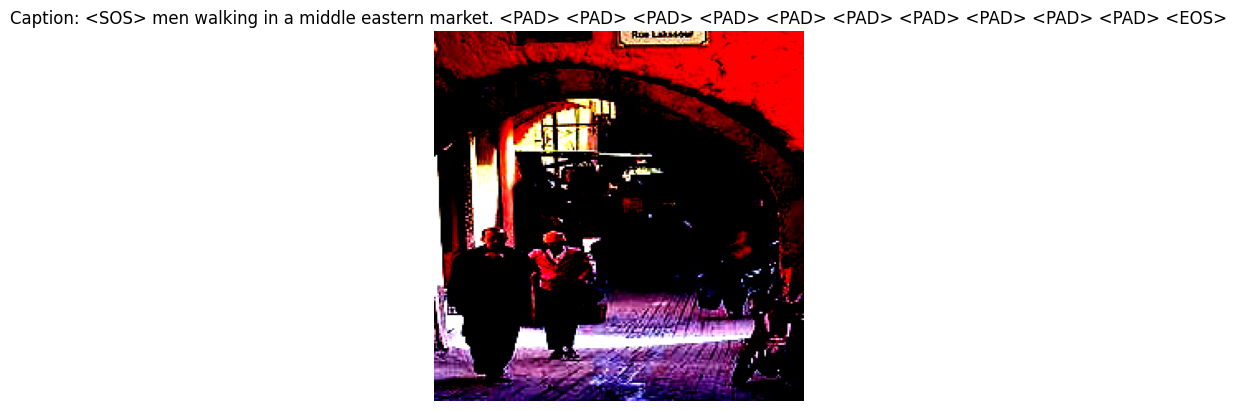

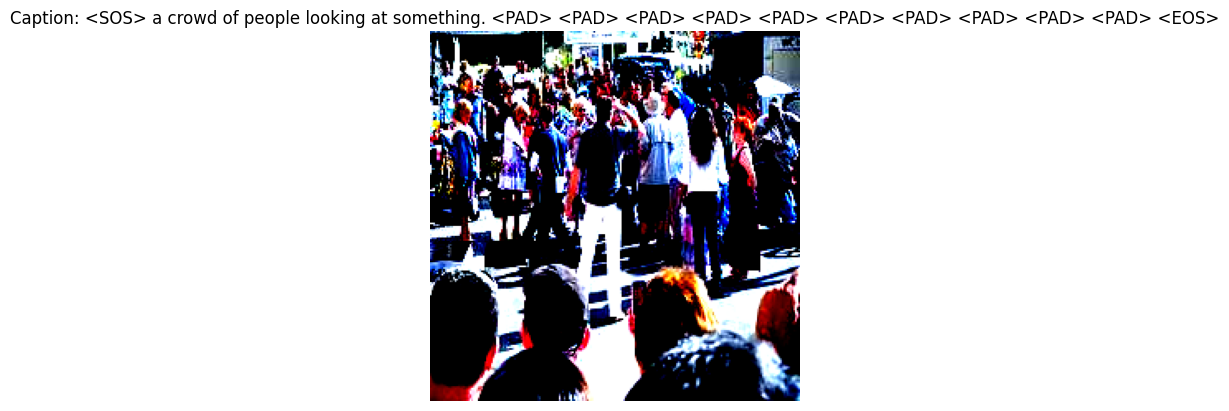

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):  # Display the first 5 samples
    plt.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.title(f"Caption: {tokenizer.decode(labels[i].tolist(), skip_special_tokens=False)}")
    plt.show()


Visualizing samples from training dataset:


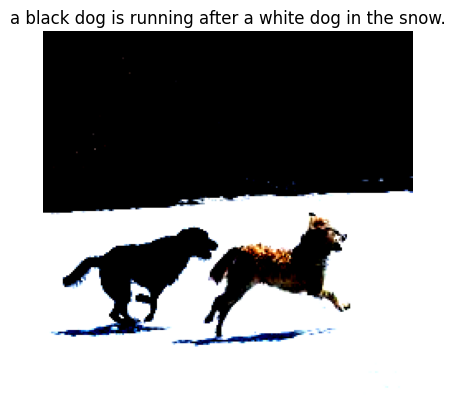

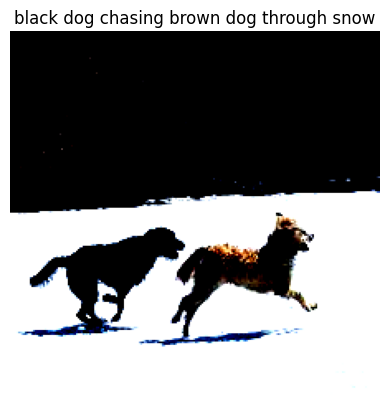

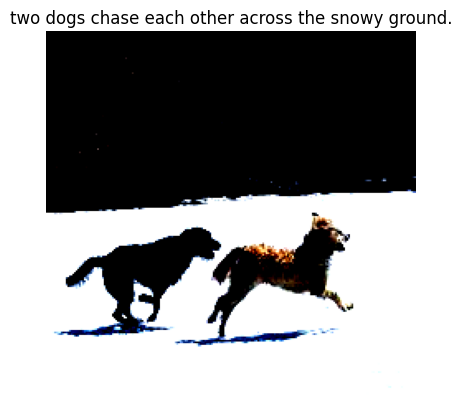

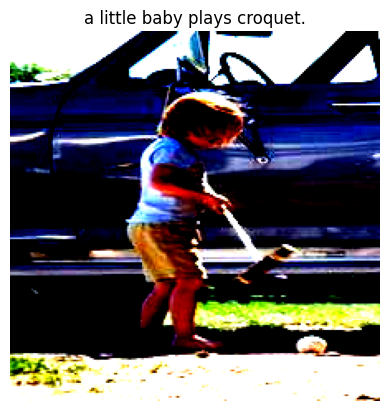

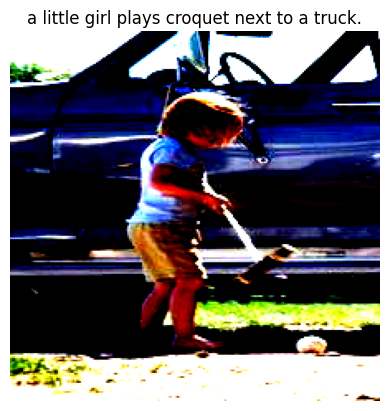

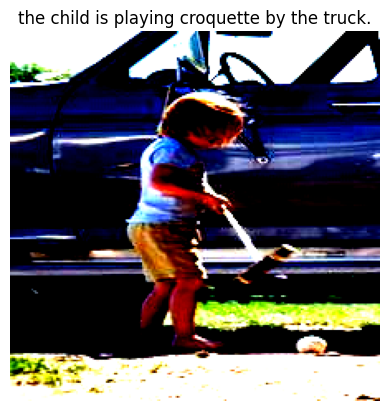

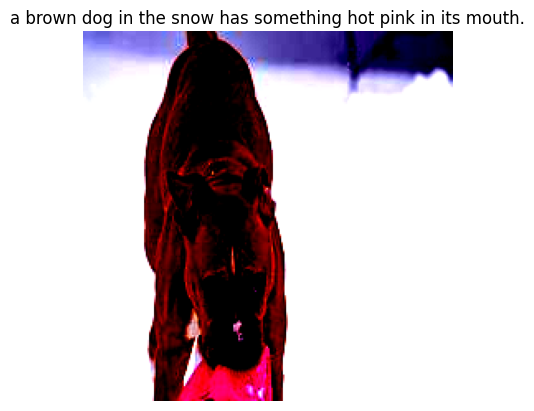

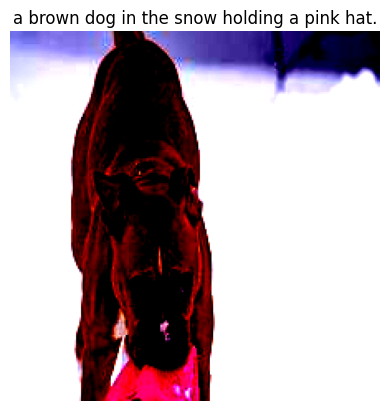

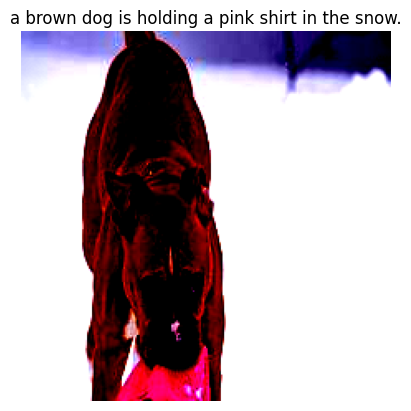

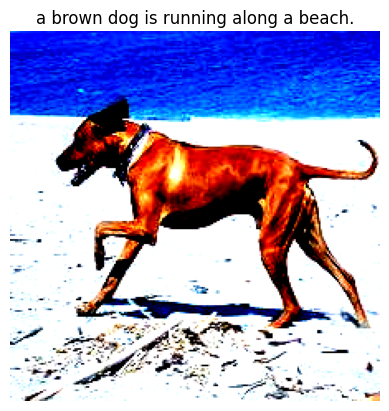

In [ ]:
def visualize_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, caption = dataset[i]
        decoded_caption = tokenizer.decode(caption.numpy(), skip_special_tokens=True)

        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title(decoded_caption)
        plt.axis('off')
        plt.show()

# Visualize before training
print("Visualizing samples from training dataset:")
visualize_samples(train_dataset, num_samples=10)

In [ ]:
class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim, in_channels = 3):
        super().__init__()
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels

        self.proj = nn.Conv2d(in_channels,
                              out_channels = self.embed_dim,
                              kernel_size = self.patch_size,
                              stride = self.patch_size)

    def forward(self, x): # x represent input image tensor.
        B, C, H, W = x.shape # B: batch size, C: Number of channels (3 for RGB), H and W: Height and Weight (224 X 224)
        assert H % self.patch_size == 0 and W % self.patch_size == 0, "Image size must be divisible by patch size"
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
        # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#Changed to pre-LN configuration
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                nn.LayerNorm(dim),
                MultiHeadAttention(dim, heads=heads, dropout=dropout, mask=False),
                nn.LayerNorm(dim),
                FeedForward(dim, dropout=dropout),

            ]) for _ in range(num_layers)
        ])

    def forward(self, x):
        for norm1, attn, norm2, ff in self.layers:
            # Multi-Head Attention with Pre-LayerNorm
            attn_input = norm1(x)  # Normalize before attention
            attn_output = attn(attn_input)  # Apply Multi-Head Attention
            x = x + attn_output  # Add residual connection

            # FeedForward Network with Pre-LayerNorm
            ffn_input = norm2(x)  # Normalize before feedforward
            ffn_output = ff(ffn_input)  # Apply FeedForward
            x = x + ffn_output  # Add residual connection

        return x


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2) * -(math.log(10000.0) / dim_model))

        pe = torch.zeros(1, max_len, dim_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [ ]:
class ViTEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, num_layers, heads, dropout):
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, embed_dim)
        self.max_words = self.patchify.num_patches
        self.pos_encoding = nn.Parameter(torch.randn(1, self.max_words,  embed_dim))
        self.transformer = Transformer(embed_dim, num_layers, heads, dropout=dropout)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, num_patches, dim)
        x = x + self.pos_encoding[:, :x.size(1), :] # Added dynamic size adjusting here so that the images can be randomly cropped
        x = self.transformer(x)      # Pass through Transformer
        return x                     # Return encoded patches (batch_size, num_patches, dim)


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads, dropout, mask):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.mask = mask

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_outputs=None):


        B, N, C = x.shape
        x = self.norm(x)

        query = self.query(x)  # (B, N, C)
        key = self.keys(x if encoder_outputs is None else encoder_outputs)  # (B, N_patches or seq_len, C)
        value = self.values(x if encoder_outputs is None else encoder_outputs)  # Same as key

        dim_head = C // self.heads


        query = query.reshape(B, N, self.heads, dim_head).permute(0, 2, 1, 3)
        key = key.reshape(B, -1, self.heads, dim_head).permute(0, 2, 1, 3)
        value = value.reshape(B, -1, self.heads, dim_head).permute(0, 2, 1, 3)


        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * (dim_head ** -0.5)

        # Apply mask
        if self.mask:
            seq_length = attention_scores.size(-1)
            causal_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)
            attention_scores = attention_scores.masked_fill(causal_mask, float("-inf"))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)


        out = torch.matmul(attention_probs, value)


        out = out.permute(0, 2, 1, 3).reshape(B, N, C)
        out = self.out_proj(out)
        return out


In [ ]:
class TransformerWithMask(nn.Module):
    def __init__(self, dim, num_layers, heads, vocab_size, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                nn.LayerNorm(dim),
                MultiHeadAttention(dim, heads, dropout, mask=True),
                nn.LayerNorm(dim),
                MultiHeadAttention(dim, heads, dropout, mask=False),
                nn.LayerNorm(dim),
                FeedForward(dim, dropout),
            ])
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_outputs):
        for norm1, masked_attn, norm2, cross_attn, norm3, ff in self.layers:
            # Masked Self-Attention with Pre-LayerNorm
            attn_input = norm1(x)
            attn_output = masked_attn(attn_input)
            x = x + attn_output  # Residual connection
            # Cross-Attention with Pre-LayerNorm
            cross_attn_input = norm2(x)
            cross_attn_output = cross_attn(cross_attn_input, encoder_outputs)
            x = x + cross_attn_output  # Residual connection
            # FeedForward with Pre-LayerNorm
            ffn_input = norm3(x)
            ffn_output = ff(ffn_input)
            x = x + ffn_output  # Residual connection
        return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self, dim_model, n_head, num_layers, vocab_size, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, dropout)
        self.dropout = nn.Dropout(dropout)  # Dropout after positional encoding
        self.linear = nn.Linear(dim_model, vocab_size)
        self.transformer = TransformerWithMask(dim_model, num_layers, n_head, dropout)

    def forward(self, captions, encoder_outputs):
        # Embed captions
        x = self.embedding(captions)

        # Add positional encoding
        x = self.positional_encoding(x)

        x = self.dropout(x)
        # Pass through transformer
        x = self.transformer(x, encoder_outputs)

        return self.linear(x)

In [ ]:
# This class used to define encoder and decoder for the whole transformer structure
class ImageCaptioning(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_layers, heads, vocab_size, max_len, dropout=0.1):
        super().__init__()

        self.encoder = ViTEncoder(img_size, patch_size, embed_dim, num_layers, heads, dropout)
        self.decoder = Decoder(embed_dim, heads,num_layers,vocab_size, dropout)

    def forward(self, captions, images):
        # Encode image patches
        encoder_out = self.encoder(images)  # (batch_size, num_patches, embed_dim)

        # Decode captions using the encoder outputs|
        decode_out = self.decoder(captions, encoder_out)  # (batch_size, max_len, vocab_size)

        return decode_out


In [ ]:
model = ImageCaptioning(img_size=224, patch_size=16, embed_dim=512, num_layers=6, heads=8, vocab_size=10000, max_len=20)
captions = torch.randint(0, 10000, (32, 20))  # Example tokenized captions
images = torch.randn(32, 3, 224, 224)  # Example image inputs
outputs = model(captions, images)
print(outputs.shape)  # Should print: (32, 20, 10000)


torch.Size([32, 20, 10000])


In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR



# Training Function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, captions in loader:
        images, captions = images.to(device), captions.to(device)
        inputs, targets = captions[:, :-1], captions[:, 1:]
        outputs = model(inputs, images)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Validation Function
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in loader:
            images, captions = images.to(device), captions.to(device)
            inputs, targets = captions[:, :-1], captions[:, 1:]
            outputs = model(inputs, images)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

# Warm-Up + Cosine Annealing Scheduler
def get_scheduler_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Linear warm-up
            return float(current_step) / float(max(1, num_warmup_steps))
        # Cosine annealing
        progress = (current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return 0.5 * (1.0 + torch.cos(torch.pi * progress))

    return LambdaLR(optimizer, lr_lambda)

num_epochs = 20
# Model
model = ImageCaptioning(
    img_size=224, patch_size=16, embed_dim=768, num_layers=4, heads=6, vocab_size=vocab_size, max_len=20,
    dropout=0.5).to(device)

# Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Define total training steps and warm-up steps
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)  # Warm-up for the first 10% of training

scheduler = get_scheduler_with_warmup(optimizer, num_warmup_steps, num_training_steps)

train_losses = []
val_losses = []

# Training Loop
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update the scheduler after each epoch
    scheduler.step()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


Epoch 1/20
Training Loss: 11.4366
Validation Loss: 10.6821
Epoch 2/20
Training Loss: 10.9592
Validation Loss: 9.4622
Epoch 3/20
Training Loss: 9.4047
Validation Loss: 7.8127
Epoch 4/20
Training Loss: 7.8221
Validation Loss: 6.7574
Epoch 5/20
Training Loss: 6.9537
Validation Loss: 6.0786
Epoch 6/20
Training Loss: 6.3694
Validation Loss: 5.6017
Epoch 7/20
Training Loss: 5.9288
Validation Loss: 5.2565
Epoch 8/20
Training Loss: 5.6063
Validation Loss: 5.0085
Epoch 9/20
Training Loss: 5.3750
Validation Loss: 4.7942
Epoch 10/20
Training Loss: 5.1927
Validation Loss: 4.6480
Epoch 11/20
Training Loss: 5.0549
Validation Loss: 4.5861
Epoch 12/20
Training Loss: 4.9437
Validation Loss: 4.4827
Epoch 13/20
Training Loss: 4.8564
Validation Loss: 4.4287
Epoch 14/20
Training Loss: 4.7767
Validation Loss: 4.3765
Epoch 15/20
Training Loss: 4.7086
Validation Loss: 4.3214
Epoch 16/20
Training Loss: 4.6443
Validation Loss: 4.3187
Epoch 17/20
Training Loss: 4.5899
Validation Loss: 4.2640
Epoch 18/20
Training

KeyboardInterrupt: 

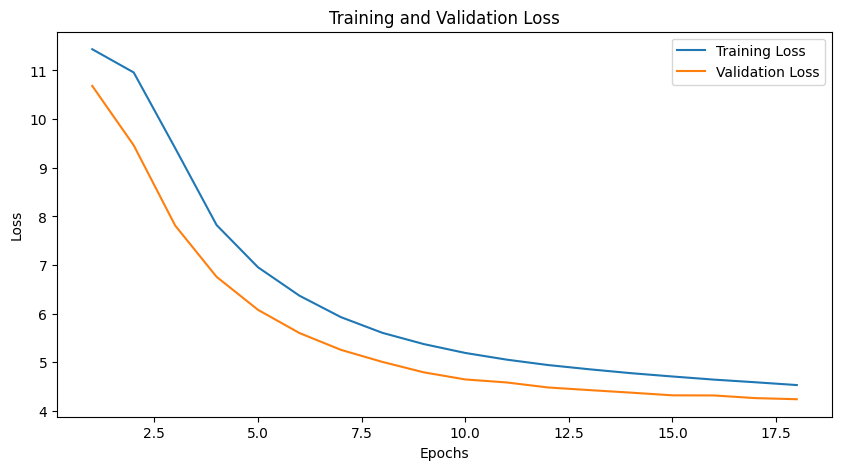

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# def load_checkpoint(path, model, optimizer, scheduler):
#     checkpoint = torch.load(path)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#     scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
#     start_epoch = checkpoint["epoch"] + 1
#     train_losses = checkpoint["train_losses"]
#     val_losses = checkpoint["val_losses"]
#     return start_epoch, train_losses, val_losses

In [ ]:
# model = ImageCaptioning(
#     img_size=224, patch_size=16, embed_dim=768, num_layers=6, heads=8, vocab_size=vocab_size, max_len=20,
#     dropout=0.5).to(device)

# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
# resume_checkpoint = "/content/drive/MyDrive/Image Captioning/checkpoints/epoch_5.pth"

In [ ]:
# if resume_checkpoint:
#     if os.path.exists(resume_checkpoint):
#         start_epoch, train_losses, val_losses = load_checkpoint(resume_checkpoint, model, optimizer, scheduler)
#         print(f"Resumed training from epoch {start_epoch}")
#     else:
#         print(f"Checkpoint not found at {resume_checkpoint}")
# else:
#     print("No checkpoint path specified.")

<ipython-input-27-ebbf0795c407>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Resumed training from epoch 5


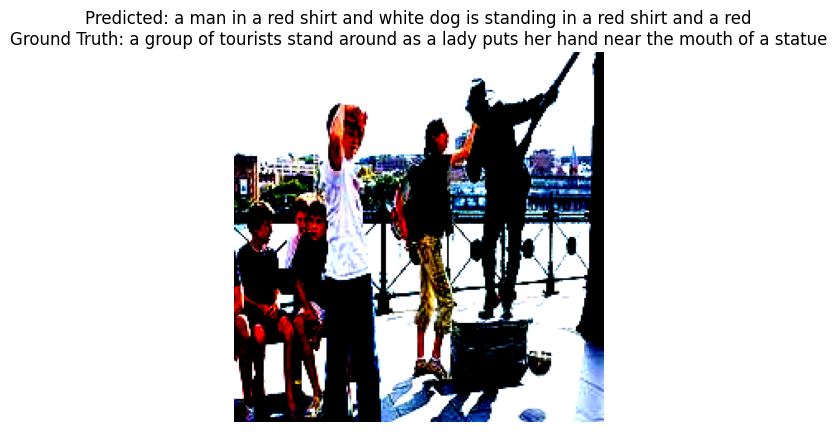

In [ ]:
model.eval()

# Select a test image by index
index_test_image = 30
test_images, gt_captions = next(iter(test_loader))
input_test_img = test_images[index_test_image].unsqueeze(0).to(device)

# Start the decoding process with the <SOS> token
decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
predicted_caption = []

# Generate the caption
with torch.no_grad():
    for _ in range(20):  # Max caption length
        outputs = model(decoder_input, input_test_img)  # Forward pass
        next_word = outputs[:, -1, :].argmax(dim=-1)  # Select the last predicted word
        predicted_caption.append(next_word.item())  # Append predicted word to the caption
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(0)], dim=1)  # Add next word to input


# Decode the predicted and ground truth captions
predicted_caption_text = tokenizer.decode(predicted_caption, skip_special_tokens=True)
ground_truth_caption_text = tokenizer.decode(gt_captions[index_test_image].cpu().numpy(), skip_special_tokens=True)

# Visualize the image with the predicted and ground truth captions
plt.imshow(test_images[index_test_image].permute(1, 2, 0).cpu().numpy())
plt.title(f"Predicted: {predicted_caption_text}\nGround Truth: {ground_truth_caption_text}")
plt.axis('off')
plt.show()


# Model Output Evaluation

In [ ]:
!pip install bert_score
!pip install git+https://github.com/michelecafagna26/cider.git#egg=cidereval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.7 MB/s eta 0:00:00
  Cloning https://github.com/michelecafagna26/cider.git to /tmp/pip-install-u_g2a5v2/cidereval_3c0530248ba24ef9ada31f667bdde381
  Running command git clone --filter=blob:none --quiet https://github.com/michelecafagna26/cider.git /tmp/pip-install-u_g2a5v2/cidereval_3c0530248ba24ef9ada31f667bdde381
  Resolved https://github.com/michelecafagna26/cider.git to commit b0c6a41335ee309bd630524d13de8a3ac6f69934
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.8/167.8 kB 9.6 MB/s 

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score
from cidereval import cider, ciderD

In [ ]:
model.eval()
index_test_image = 30
predicted_captions = []
ground_truth_captions = []

# Get a batch of test images
test_images, gt_captions = next(iter(test_loader))

for i in range(index_test_image):
  input_test_img = test_images[i].unsqueeze(0).to(device)

  decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
  predicted_caption = []

  with torch.no_grad():
      for _ in range(20):  # Max caption length
          outputs = model(decoder_input, input_test_img)
          next_word = outputs.argmax(dim=-1)[:, -1]
          predicted_caption.append(next_word.item())
          decoder_input = torch.cat([decoder_input, next_word.unsqueeze(0)], dim=1)
          if next_word.item() == tokenizer.eos_token_id:
              break

  predicted_caption = tokenizer.decode(predicted_caption, skip_special_tokens=True)
  ground_truth_caption = tokenizer.decode(gt_captions[i].cpu().numpy(), skip_special_tokens=True)

  predicted_captions.append(predicted_caption)
  ground_truth_captions.append(ground_truth_caption)

In [ ]:
predicted_sentences = []
true_sentences = []

for i in ground_truth_captions:
  sentence = [i.lower().replace('.', '').strip()]
  true_sentences.append(sentence)
for i in predicted_captions:
    sentence = [i.lower().replace('.', '').strip()]
    predicted_sentences.append(sentence)

Tokenize the sentences

In [ ]:
predicted_sentences_tokenized = []

for i in predicted_sentences:
  sentences = []
  for j in i:
    sentences.append(j.split())
  predicted_sentences_tokenized.append(sentences)

In [ ]:
print(predicted_sentences_tokenized)

[[['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'a', 'red', 'shirt', 'and', 'white', 'dog']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'a', 'red', 'shirt', 'and', 'white', 'dog']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'a', 'red', 'shirt', 'and', 'white', 'dog']], [['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'swimming']], [['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'swimming']], [['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'swimming']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'red']], [['a',

In [ ]:
true_sentences_tokenized = []

for i in true_sentences:
  sentences = []
  for j in i:
    sentences.append(j.split())
  true_sentences_tokenized.append(sentences)

In [ ]:
print(true_sentences_tokenized)

[[['the', 'dogs', 'are', 'in', 'the', 'snow', 'in', 'front', 'of', 'a', 'fence']], [['the', 'dogs', 'play', 'on', 'the', 'snow']], [['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow']], [['a', 'brown', 'and', 'white', 'dog', 'swimming', 'towards', 'some', 'in', 'the', 'pool']], [['a', 'dog', 'in', 'a', 'swimming', 'pool', 'swims', 'toward', 'sombody', 'we', 'cannot', 'see']], [['a', 'dog', 'swims', 'in', 'a', 'pool', 'near', 'a', 'person']], [['a', 'man', 'and', 'a', 'woman', 'in', 'festive', 'costumes', 'dancing']], [['a', 'man', 'and', 'a', 'woman', 'with', 'feathers', 'on', 'her', 'head', 'dance']], [['a', 'man', 'and', 'a', 'woman', 'wearing', 'decorative', 'costumes', 'and', 'dancing', 'in', 'a', 'crowd', 'of', 'onlookers']], [['a', 'couple', 'of', 'people', 'sit', 'outdoors', 'at', 'a', 'table', 'with', 'an', 'umbrella', 'and', 'talk']], [['three', 'people', 'are', 'sitting', 'at', 'an', 'outside', 'picnic', 'bench', 'with', 'an', 'umbrella']], [['three', 'people'

Calculate BLEU Scores

In [ ]:
# Good BLEU-1 scores are in the range of 60-80
# Good BLEU-4 scores are in the range of 30-40

# Initialize lists to store individual sentence BLEU scores
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

# Iterate through each sentence pair
for ref, hyp in zip(true_sentences_tokenized, predicted_sentences_tokenized):

    # Calculate BLEU scores for the current sentence pair
    bleu1_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 1.0,)))
    bleu2_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 2.0, 1.0 / 2.0,)))
    bleu3_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0,)))
    bleu4_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0,)))

# Calculate the average BLEU scores across all sentences
bleu1 = sum(bleu1_scores) / len(bleu1_scores)
bleu2 = sum(bleu2_scores) / len(bleu2_scores)
bleu3 = sum(bleu3_scores) / len(bleu3_scores)
bleu4 = sum(bleu4_scores) / len(bleu4_scores)

print('BLEU-1: {}\nBLEU-2: {}\nBLEU-3: {}\nBLEU-4: {}\n'.format(bleu1, bleu2, bleu3, bleu4))

BLEU-1: 0.20227629841463707
BLEU-2: 0.05457889891654933
BLEU-3: 0.0043338606838827275
BLEU-4: 8.814790683327941e-80



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
print(predicted_sentences)

[['a man in a red shirt is standing in a red shirt and white dog'], ['a man in a red shirt is standing in a red shirt and white dog'], ['a man in a red shirt is standing in a red shirt and white dog'], ['a man in a blue shirt is swimming'], ['a man in a blue shirt is swimming'], ['a man in a blue shirt is swimming'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a dog is running through the grass'], ['a dog is running through the grass'], ['a dog is running through the grass'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'], ['a man in a red shirt is standing on a red'

Calculate BERT Score

In [ ]:
# Good BERT scores are in the range of 0.85-0.9

P, R, F1 = score([s[0] for s in predicted_sentences], [s[0] for s in true_sentences], lang="en", verbose=True)  # Flatten predicted_sentences and true_sentences
print(f"System level F1 score: {F1.mean():.3f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.50 seconds, 59.80 sentences/sec
System level F1 score: 0.868


In [ ]:
len(true_sentences)

30

Calculate CiDEr Score

In [ ]:
# Good CiDEr scores are from 80-100

preds = [s[0] for s in predicted_sentences]
refs = [s[0] for s in true_sentences]

# Calculate CiDEr Score
print(cider(predictions=preds, references=refs)['avg_score'])

0.00011346015241103753


# Pretrained EfficientNetv2-Small Model Baseline

In [ ]:
import torch
import torchvision.models as models
from torch import nn
from torchvision import transforms
from PIL import Image

Load and prepare the model

In [ ]:
# Load the model
EfficientNetv2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
# Freeze the model
EfficientNetv2.eval()

In [ ]:
# Freeze all parameters
for param in EfficientNetv2.parameters():
    param.requires_grad = False

In [ ]:
# Drop the last (classification) layer
efficientnet_features = nn.Sequential(*list(EfficientNetv2.children())[:-1])

In [ ]:
# Get the model transforms as defined by the model weights
EfficientNet_transforms = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()

Get visual features of an image from the model

In [ ]:
# Example image
image = Image.open('/content/drive/MyDrive/Deep_Learning/Resized_Images/1000268201_693b08cb0e.jpg')

In [ ]:
image_tensor = EfficientNet_transforms(image).unsqueeze(0)

with torch.no_grad():
    visual_features = efficientnet_features(image_tensor)

In [ ]:
visual_features.shape